# Donut Model Training for Invoice Extraction
This notebook demonstrates how to train a Donut model on invoice data with proper validation and metrics.

In [1]:
# Install required packages
#!pip install transformers==4.31.0 datasets torch torchvision seqeval accelerate -q

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import json
from datasets import Dataset, DatasetDict
from transformers import (
    DonutProcessor,
    VisionEncoderDecoderModel,
    TrainingArguments,
    default_data_collator,
    Trainer
)
import torch
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## 1. Load and Prepare Dataset
We'll load both train and validation splits, filtering out corrupt JSONs.

In [3]:
def load_split(split='train'):
    image_dir = f'../data/invoices-donut/{split}'
    json_dir = f'../data/invoices-donut/donut_json/{split}'
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    data = []
    
    for img_file in tqdm(image_files, desc=f'Loading {split} split'):
        img_path = os.path.join(image_dir, img_file)
        json_path = os.path.join(json_dir, os.path.splitext(img_file)[0] + '.json')
        if os.path.exists(json_path):
            with open(json_path, 'r', encoding='utf-8') as f:
                label = json.load(f)
                # Skip corrupt JSONs (those with raw_response key)
                if 'raw_response' in label:
                    try:
                        label = json.loads(label['raw_response'])
                    except:
                        print(f"Skipping corrupt JSON: {img_file}")
                        continue
            # Flatten label: convert all values to strings, including items
            flat_label = {}
            for k, v in label.items():
                if isinstance(v, (dict, list)):
                    flat_label[k] = json.dumps(v, ensure_ascii=False)
                else:
                    flat_label[k] = str(v)
            data.append({'image_path': img_path, **flat_label})
    return data

# Load both splits
train_data = load_split('train')
val_data = load_split('valid')
print(f'Loaded {len(train_data)} training and {len(val_data)} validation image-label pairs.')

Loading train split:   0%|          | 0/420 [00:00<?, ?it/s]

Skipping corrupt JSON: train-351.jpg
Skipping corrupt JSON: train-81.jpg


Loading valid split:   0%|          | 0/52 [00:00<?, ?it/s]

Loaded 418 training and 52 validation image-label pairs.


## 2. Visualize Sample
Let's check a random sample to ensure data loading works correctly.

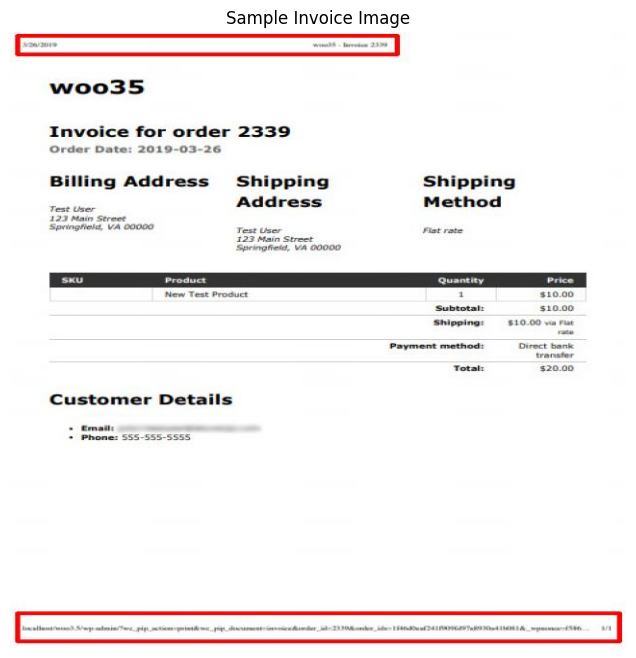

Label: {
  "supplier_name": "",
  "supplier_address": "J23Main Sereee, Spnged. VA 0, Farete, SpeoRed VA COoO0",
  "customer_name": "Tet user",
  "customer_address": "123 Main Stcet, SpeoRed VA COoO0",
  "invoice_number": "woo35",
  "invoice_date": "2019-03-26",
  "due_date": "",
  "tax_amount": "$10.00F",
  "tax_rate": "",
  "invoice_subtotal": "$10.00",
  "invoice_total": "$20.00",
  "items": "[{\"item_description\": \"New Test Prodct\", \"item_quantity\": \"S0.0\", \"item_unit_price\": \"$10.00\", \"item_total_price\": \"\"}]"
}


In [4]:
sample = random.choice(train_data)
img = Image.open(sample['image_path'])
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Sample Invoice Image')
plt.show()
label_dict = {k: v for k, v in sample.items() if k != 'image_path'}
print('Label:', json.dumps(label_dict, indent=2, ensure_ascii=False))

## 3. Load Model and Processor
Using the base Donut model with proper initialization.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print(f"Using device: {device}")
# Initialize model and processor
model_name = "naver-clova-ix/donut-base"

# Use AutoProcessor for more reliable initialization
processor = DonutProcessor.from_pretrained(model_name)
model = VisionEncoderDecoderModel.from_pretrained(model_name)

# Set up model configuration
model.config.decoder_start_token_id = processor.tokenizer.bos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# Generation parameters
model.config.max_length = 512
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

# Move to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
model.to(device)

c:\projects\extracteur_de_factures\venv311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Using device: cuda


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\torch\nn\modules\module.py:1150: UserWarning: expandable_segments not supported on this platform (Triggered internally at ..\c10/cuda/CUDAAllocatorConfig.h:30.)
  return t.to(device, dtype if t.is_floating_point() or t.is_complex() else None, non_blocking)


VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

## 4. Prepare Dataset
Convert data into the format expected by Donut.

In [ ]:
def preprocess(example, processor):
    import json
    from PIL import Image

    pixel_values = []
    input_ids_list = []
    target_sequences = []

    batch_size = len(example['image_path'])
    label_keys = [k for k in example.keys() if k != 'image_path']

    for i in range(batch_size):
        label_dict = {k: example[k][i] for k in label_keys}
        image = Image.open(example['image_path'][i]).convert('RGB').resize((384, 384))
        pixel_values.append(processor(image, return_tensors='pt').pixel_values[0])

        task_prompt = "<s_invoice>"
        label_str = json.dumps(label_dict, ensure_ascii=False)
        target_sequence = f"{task_prompt}{label_str}</s_invoice>"
        target_sequences.append(target_sequence)

        input_ids = processor.tokenizer(
            target_sequence,
            padding='max_length',
            max_length=512,
            truncation=True,
            return_tensors='pt'
        ).input_ids[0]
        input_ids_list.append(input_ids)

    return {
        'pixel_values': pixel_values,
        'labels': input_ids_list,
        'target_sequence': target_sequences
    }

print("Preparing datasets...")
# Create and process datasets
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)

print("Processing training dataset...")
train_dataset = train_dataset.map(
    preprocess,
    remove_columns=train_dataset.column_names,
    num_proc=1,
    fn_kwargs={'processor': processor},
    batched=True,
    batch_size=8,
    keep_in_memory=False
)

print("Processing validation dataset...")
val_dataset = val_dataset.map(
    preprocess,
    remove_columns=val_dataset.column_names,
    num_proc=1,
    fn_kwargs={'processor': processor},
    batched=True,
    batch_size=8,
    keep_in_memory=False
)

# Combine into DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

dataset.set_format(type='torch', columns=['pixel_values', 'labels'])
print("Dataset preparation complete.")

Preparing datasets...
Processing training dataset...


Map:   0%|          | 0/418 [00:00<?, ? examples/s]

Processing validation dataset...


Map:   0%|          | 0/52 [00:00<?, ? examples/s]

Dataset preparation complete.


## 5. Define Metrics
Setup evaluation metrics including per-field accuracy.

In [8]:
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    labels = eval_pred.label_ids
    
    # Decode outputs
    pred_str = processor.tokenizer.batch_decode(predictions, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    def extract_json_from_text(text):
        try:
            start_tag = "<s_invoice>"
            end_tag = "</s_invoice>"
            if start_tag in text and end_tag in text:
                json_text = text[text.find(start_tag) + len(start_tag):text.find(end_tag)]
            else:
                json_start = text.find('{')
                json_end = text.rfind('}')
                if json_start >= 0 and json_end > json_start:
                    json_text = text[json_start:json_end + 1]
                else:
                    return None
            return json.loads(json_text.strip())
        except (json.JSONDecodeError, ValueError):
            return None
    
    # Calculate metrics
    exact_matches = 0
    field_matches = {}
    total_samples = len(pred_str)
    valid_predictions = 0
    
    for pred, label in zip(pred_str, label_str):
        pred_json = extract_json_from_text(pred)
        label_json = extract_json_from_text(label)
        
        if pred_json is not None:
            valid_predictions += 1
            
            if pred_json == label_json:
                exact_matches += 1
            
            if label_json is not None:
                for field in label_json.keys():
                    if field not in field_matches:
                        field_matches[field] = {'correct': 0, 'total': 0}
                    
                    field_matches[field]['total'] += 1
                    if field in pred_json and pred_json[field] == label_json[field]:
                        field_matches[field]['correct'] += 1
    
    # Compile metrics
    accuracy = exact_matches / total_samples if total_samples > 0 else 0
    valid_ratio = valid_predictions / total_samples if total_samples > 0 else 0
    
    field_accuracies = {
        field: {'accuracy': matches['correct'] / matches['total'] if matches['total'] > 0 else 0}
        for field, matches in field_matches.items()
    }
    
    metrics = {
        'exact_match_accuracy': accuracy,
        'valid_predictions_ratio': valid_ratio,
        'num_exact_matches': exact_matches,
        'num_valid_predictions': valid_predictions,
        'total_samples': total_samples,
    }
    
    # Add field-level accuracies
    for field, field_metric in field_accuracies.items():
        metrics[f'accuracy_{field}'] = field_metric['accuracy']
    
    return metrics

## 6. Train Model
Configure training arguments and start training.

In [ ]:
training_args = TrainingArguments(
    output_dir='./donut-finetuned-invoice',
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    save_steps=100,
    save_total_limit=2,
    logging_steps=10,
    learning_rate=5e-5,
    gradient_checkpointing=True,  # Trade compute for memory
    fp16=torch.cuda.is_available(),
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='exact_match_accuracy',
    gradient_accumulation_steps=4,  # For larger effective batch size
    max_grad_norm=1.0,
    warmup_ratio=0.1,              # Gradual warmup
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    tokenizer=processor.tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics
)

print("Starting training...")
train_results = trainer.train()

print("\nEvaluating model...")
eval_results = trainer.evaluate()

print("\nTraining Results:")
print(json.dumps(train_results, indent=2))
print("\nEvaluation Results:")
print(json.dumps(eval_results, indent=2))

Starting training...


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/260 [00:00<?, ?it/s]

c:\projects\extracteur_de_factures\venv311\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing`. Setting `use_cache=False`...


## 7. Save Model
Save the fine-tuned model and processor.

In [ ]:
output_dir = '../backend/models/donut-finetuned-invoice'
print(f"Saving model to {output_dir}...")
model.save_pretrained(output_dir)
processor.save_pretrained(output_dir)
print("Model and processor saved successfully!")